<a href="https://colab.research.google.com/github/tevrat-aksoy/Thyroid_Classification/blob/main/thyroid_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TROID SINIFLANDIRMA**

**1)** Kullanılan kütüphanelerin kurulumu yapılır.

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
!pip install tensorflow-addons

In [ ]:
from zipfile import ZipFile
import pandas as pd
import os
import opendatasets as od
import cv2
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
from tensorflow import keras
import xml.dom.minidom
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB4,InceptionV3,VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

**2)** Kullanılan veri seti indirilir ve klasöre aktarılır.

In [ ]:
dataset_url = 'http://cimalab.intec.co/applications/thyroid/thyroid.zip'
od.download(dataset_url)

  0%|          | 0/17982416 [00:00<?, ?it/s]

 92%|█████████▏| 16605184/17982416 [00:01<00:00, 13497722.80it/s]

In [ ]:
datasetpath="./dataset"

datasetpath2="./processed_dataset"

testpath="./testset"

if os.path.isdir(datasetpath) is False:
        os.mkdir(datasetpath)

if os.path.isdir(datasetpath2) is False:
        os.mkdir(datasetpath2)
        
if os.path.isdir(testpath) is False:
        os.mkdir(testpath)       

import zipfile
with zipfile.ZipFile("./thyroid.zip", 'r') as zip_ref:
    zip_ref.extractall(datasetpath)

if os.path.isdir(datasetpath2+"/malign") is False:
        os.mkdir(datasetpath2+"/malign")
if os.path.isdir(datasetpath2+"/benign") is False:
        os.mkdir(datasetpath2+"/benign")

if os.path.isdir(testpath+"/malign") is False:
        os.mkdir(testpath+"/malign")
if os.path.isdir(testpath+"/benign") is False:
        os.mkdir(testpath+"/benign")

**3)** Her bir "xml" dosyası içerisinde "tirads" skoru kontrol edilerek görüntüler "prossed_dataset" klasörüne aktarılır. Skoru verilmeyen görüntüler veri setinde kullanılmamıştır.

Veri setindeki görüntüler farklı yazı ve işaretlemeler içermektedir. Model performansını artırmak için opencv ile bu değerler azaltılmıştır.

 2 ve 3 skoruna sahip olan görüntüler "benign", diğerleri "malign" klasörüne aktarılır. Aynı zamanda "benign" sınıfına sahip görüntüler az sayıdadır. Bu nedenle olaşabilecek "data imbalance" sorununu engellemek için "benign" görüntüler iki adet olarak kullanılır.

In [ ]:
test_bening_image=0
test_malign_image=0

for file_no in range(1,400):

  #xml dosyalari icerisinde bazı verilerin tirads skoru olmadigi icin bu veriler alinmamistir.
  try: 
    #xml dosyalari icerisinde tirads skorlari her bir görüntü icin alinir.
    doc = xml.dom.minidom.parse(datasetpath+"/"+str(file_no)+".xml")
    tirads = doc.getElementsByTagName("tirads")

    #tirads skorlari 2 ve 3 olan goruntuler secilir
    if tirads[0].firstChild.data =="2" or tirads[0].firstChild.data =="3":
    
      image_count = doc.getElementsByTagName("image")
      num_image=int(image_count[0].firstChild.data)
    
      #Ayni xml dosyasında birden fazla goruntu oldugu icin bu goruntuler tek tek secılır
      for im_no in range(num_image):
        im_name=datasetpath+"/"+str(file_no)+"_"+str(im_no+1)+".jpg"
        img = cv2.imread(im_name)

        #Goruntu icerisindeki yazi ve isaretlemer threshold fonksiyonu ile azaltilmistir.
        mask = cv2.threshold(img, 210, 255, cv2.THRESH_BINARY)[1][:,:,0]
        dst = cv2.inpaint(img, mask, 7, cv2.INPAINT_NS)
        
        #test seti icin tolpam verinin yuzde 20'si kullanilir.
        if test_bening_image<12:
        
            cv2.imwrite(testpath +"/benign"+ "/"+str(file_no)+"_"+str(im_no+1)+".jpg", dst)
            test_bening_image=test_bening_image+1
        else:
            
            cv2.imwrite(datasetpath2 +"/benign"+ "/"+str(file_no)+"_"+str(im_no+1)+".jpg", dst)
        


    else:

      image_count = doc.getElementsByTagName("image")
      num_image=int(image_count[0].firstChild.data)

      for im_no in range(num_image):
        im_name=datasetpath+"/"+str(file_no)+"_"+str(im_no+1)+".jpg"
        img = cv2.imread(im_name)

        #Goruntu icerisindeki yazi ve isaretlemer threshold fonksiyonu ile azaltilmistir.
        mask = cv2.threshold(img, 210, 255, cv2.THRESH_BINARY)[1][:,:,0]
        dst = cv2.inpaint(img, mask, 7, cv2.INPAINT_NS)
        
        #test seti icin tolpam verinin yuzde 20'si kullanilir.
        if test_malign_image<52:
        
            cv2.imwrite(testpath +"/malign"+ "/"+str(file_no)+"_"+str(im_no+1)+".jpg", dst)
            test_malign_image=test_malign_image+1
        else:
            #Goruntuler malign klasorune kaydedilir.
            cv2.imwrite(datasetpath2 +"/malign"+ "/"+str(file_no)+"_"+str(im_no+1)+".jpg", dst)  

  except:
    pass
  #   print (str(file_no)+" not exist")



17989632it [00:01, 9187558.94it/s]                               


In [ ]:
ath, dirs, files = next(os.walk("./processed_dataset/benign"))
print("Train+ validation benign image number "+str(len(files)))
      
ath, dirs, files = next(os.walk("./processed_dataset/malign"))
print("Train+ validation malign image number "+str(len(files)))

ath, dirs, files = next(os.walk("./testset/benign"))
print("test benign image number "+str(len(files)))

ath, dirs, files = next(os.walk("./testset/malign"))
print("testvalidation malign image number "+str(len(files)))

Train+ validation benign image number 44
Train+ validation malign image number 216
test benign image number 12
testvalidation malign image number 52


**4)** Opencv ile yapılan işlem sonucu görüntülerde yazı ve işaretlemelerin azaldığı görülmektedir.

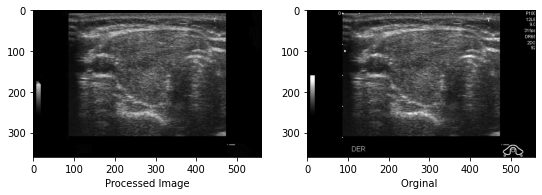

In [ ]:
img=cv2.imread("./processed_dataset/benign/193_1.jpg")
img2=cv2.imread("./dataset/193_1.jpg")

plt.figure(figsize=(9, 28))
ax = plt.subplot(1, 2, 1)
plt.imshow(img)
plt.xlabel("Processed Image")
ax = plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.xlabel("Orginal ")
plt.show()


**5)** Modelin giriş verileri için 360x360 boyutu kullanılır. Veri sayısı az olduğu için augmentation yöntemleri ile veri sayısı artırılmıştır. Daha sonra veri seti train ve validation setlerine ayrılmıştır.

In [ ]:
batch_size = 16
img_height = 360
img_width = 360

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Data augmentation uygulanarak veri sayisi artirilmistir. Veri seti %60 train, %20 validation ve %20 test olarak ayrilmistir.
datagen = ImageDataGenerator(
    
                            rescale=1./255,
                            #preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
    
                            validation_split=0.2,
                            shear_range=0.05,
                            zoom_range=0.05,
                            rotation_range=0.05,
                            fill_mode='nearest',
    
                             )

train_set= datagen.flow_from_directory(
    datasetpath2,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary',
    subset='training',
    )

val_set= datagen.flow_from_directory(
    datasetpath2,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary',
    subset='validation',
    )




Found 209 images belonging to 2 classes.
Found 51 images belonging to 2 classes.


In [ ]:
testgen = ImageDataGenerator(
                            #preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
                            rescale=1./255,
                             )
test_set= testgen.flow_from_directory(
    testpath,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary',
    subset='training',
    )

Found 64 images belonging to 2 classes.


In [ ]:
test_set.labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

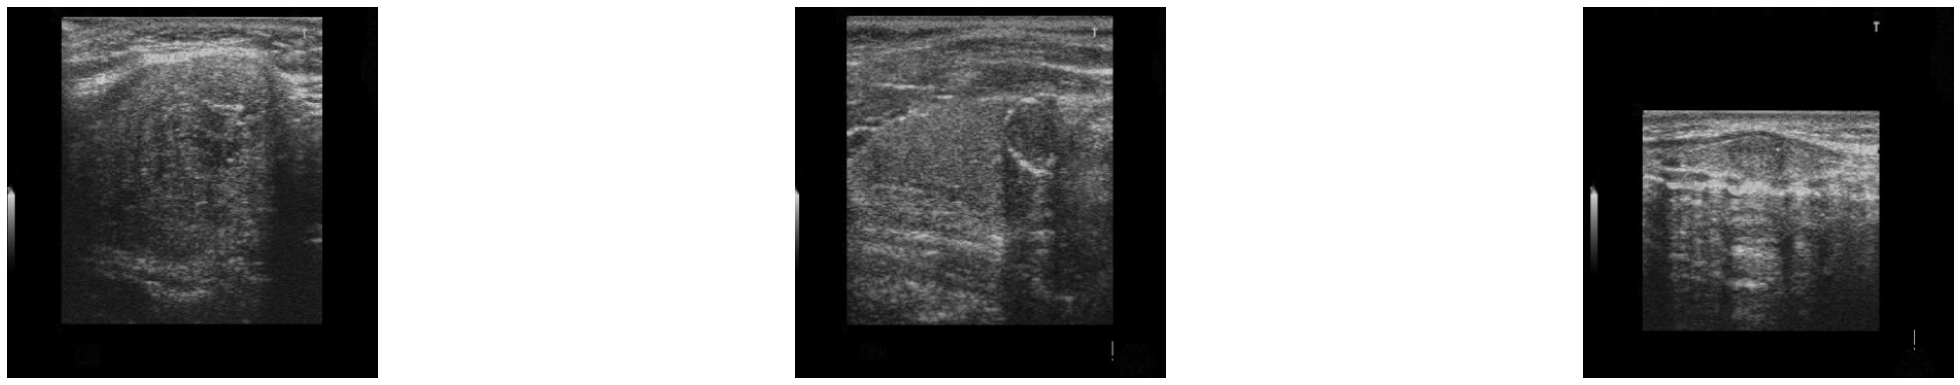

In [ ]:
import matplotlib.pyplot as plt

n = 3
plt.figure(figsize=(40, 15))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(train_set[i][0][0])
    ax.axis('off')

plt.show()

**6)** Geliştirilen model için Inception modeli ile transfer learning tekniği kullanılmıştır. Inception modeli için son 5 katman eğitime dahil edilmiştir.

In [ ]:
inception_model = InceptionV3 (
    input_shape=(img_height, img_width, 3),
    weights="imagenet",
    include_top=False,  
)

In [ ]:
#Modelin son 5 katmani egitilebilir yapilmistir.
inception_model.trainable = True
print("Number of Layers", len(inception_model.layers))
fine_tune_at = 306

for layer in inception_model.layers[:fine_tune_at]:
  layer.trainable =  False



Number of Layers 311


In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.00005,
    decay_steps=100000,
    decay_rate=0.90,
)

opt = Adam(learning_rate=lr_schedule)

**7)** Model girişinde 360x360 boyutunda görüntüler alınmaktadır. Daha sonra Inception modeli ile transfer learning metodu kullanılmıştır. 


Modelde "dropout" katmanı kullanılarak "overfitting" engellenmeye çalışılmıştır.


İkili sınıflandırma yapıldığı için son katmanda 1 nöron kullanıldı ve aktivasyon sigmoid seçildi.

Optimizasyon için Adam metodu seçilmiştir. Model ölçümünde accuracy ve f1 skoru hesaplanmaktadır. 

In [ ]:
def create_model():
    model = Sequential()
    model.add(inception_model)
    model.add(layers.GlobalMaxPooling2D())
    model.add(layers.Dense(units=128, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(units=1, activation='sigmoid'))
    

    model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy', tfa.metrics.F1Score(num_classes=1, average='macro',threshold=0.5)])
    
    return model
model=create_model()

In [ ]:
#Model 20 tur egitilmistir.
history = model.fit(train_set,
                    validation_data=val_set,
                    epochs=20,
                    batch_size=batch_size,
                    )

Epoch 1/20
14/14 [==============================] - 12s 637ms/step - loss: 1.6270 - accuracy: 0.5932 - f1_score: 0.7102 - val_loss: 0.9893 - val_accuracy: 0.8431 - val_f1_score: 0.9149
Epoch 2/20
14/14 [==============================] - 7s 542ms/step - loss: 0.9402 - accuracy: 0.7833 - f1_score: 0.8765 - val_loss: 0.4004 - val_accuracy: 0.8627 - val_f1_score: 0.9195
Epoch 3/20
14/14 [==============================] - 8s 592ms/step - loss: 0.9452 - accuracy: 0.6558 - f1_score: 0.7675 - val_loss: 0.5429 - val_accuracy: 0.8431 - val_f1_score: 0.9149
Epoch 4/20
14/14 [==============================] - 8s 534ms/step - loss: 0.7408 - accuracy: 0.7591 - f1_score: 0.8522 - val_loss: 0.3903 - val_accuracy: 0.8431 - val_f1_score: 0.9149
Epoch 5/20
14/14 [==============================] - 8s 547ms/step - loss: 0.9519 - accuracy: 0.7095 - f1_score: 0.8261 - val_loss: 0.4442 - val_accuracy: 0.8431 - val_f1_score: 0.9149
Epoch 6/20
14/14 [==============================] - 7s 511ms/step - loss: 0.711

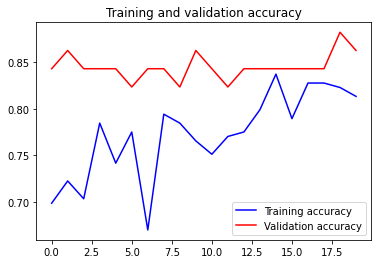

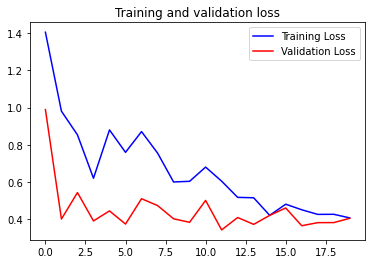

In [ ]:
def plot_result(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

plot_result(history)


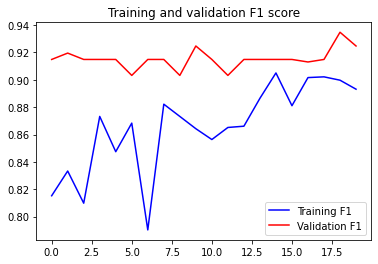

<Figure size 432x288 with 0 Axes>

In [ ]:
def plot_result(history):
    f1 = history.history['f1_score']
    val_f1 = history.history['val_f1_score']
    epochs = range(len(f1))

    plt.plot(epochs, f1, 'b', label='Training F1')
    plt.plot(epochs, val_f1, 'r', label='Validation F1')
    plt.title('Training and validation F1 score')
    plt.legend()
    plt.figure()

plot_result(history)


In [ ]:
result=model.evaluate(test_set)

4/4 [==============================] - 0s 99ms/step - loss: 0.5662 - accuracy: 0.8125 - f1_score: 0.8929
